## Purpose

The purpose of this script is to see if there is a correlation between our annual smoke estimate and the recreation visitors in Death Valley, as well as if there is a correlation between our AQI estimate and recreation visitors in Death Valley.

We will begin by importing basic python libraries.

In [26]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm

#Loading files
smoke_estimate = pd.read_csv('../clean_data/annual_smoke_estimate.csv')
aqi_estimate = pd.read_csv('../clean_data/yearly_avg_aqi.csv')
death_valley = pd.read_csv('../raw_data/Annual Park Recreation Visitation (1904 - Last Calendar Year).csv')

For ease of graphing we will combine the smoke, AQI and Death Valley dataframes using the below code.

In [27]:
#Combine smoke estimate into death valley
comb_df = pd.merge(left=smoke_estimate, right=death_valley, 
                   left_on='Fire_Year', right_on='Year',
                  how = 'left')

#Add in aqi estimate
comp_df = pd.merge(left =comb_df, right = aqi_estimate,
                  left_on='Fire_Year', right_on='year',
                  how = 'left')

#Remove unnecessary or repeated columns
comp_df = comp_df[['Year','Annual_Smoke_Estimate',
                  'RecreationVisitors','annual_avg_aqi']]

#Update format of RecreationVisitors
comp_df['RecreationVisitors'] = comp_df['RecreationVisitors'].str.replace(',','')
comp_df['RecreationVisitors'] = comp_df['RecreationVisitors'].astype(str).astype(int)

Now we will visually compare Death Valley attendance and our smoke estimate. Note that the smoke estimate is in single units, whereas attendance is measured in millions.

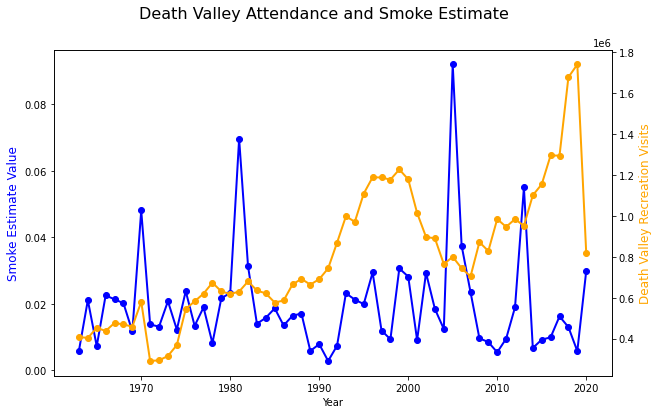

In [28]:
#Plotting the timeseries
x = comp_df['Year']
y_death_valley = comp_df['RecreationVisitors']
y_smoke = comp_df['Annual_Smoke_Estimate']

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot()

color = 'blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate Value', size=12, color=color)
ax1.plot(x, y_smoke, marker='o', linestyle='solid',
     linewidth=2, markersize=6, color=color)

ax2 = ax1.twinx() #makes second plot which shares x axis

color = 'orange'
ax2.set_ylabel('Death Valley Recreation Visits', size=12, color=color)
ax2.plot(x, y_death_valley, marker='o', linestyle='solid',
     linewidth=2, markersize=6, color = color)

fig.suptitle("Death Valley Attendance and Smoke Estimate", size=16)
plt.show()

From the above plot it does not appear that Death Valley attendance and smoke estimates in Pahrump are correlated. However, we will normalize both measurements and validate the correlation via linear regression.

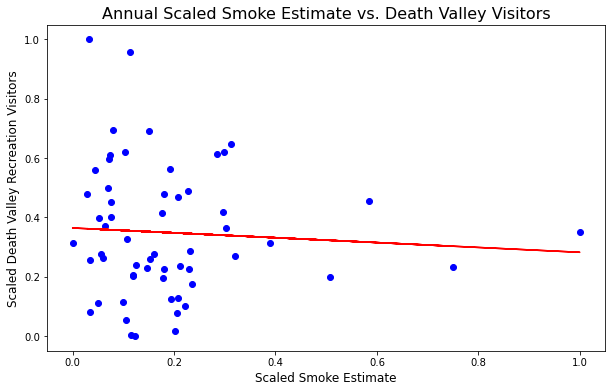

The r-squared value for the linear regression is 0.0.
The p value is 0.63


In [29]:
#Normalizing the columns
df_min_max_scaled = comp_df.copy() 
df_min_max_scaled['scaled_smoke'] = (df_min_max_scaled['Annual_Smoke_Estimate'] - df_min_max_scaled['Annual_Smoke_Estimate'].min()) / (df_min_max_scaled['Annual_Smoke_Estimate'].max() - df_min_max_scaled['Annual_Smoke_Estimate'].min())     
df_min_max_scaled['scaled_aqi'] = (df_min_max_scaled['annual_avg_aqi'] - df_min_max_scaled['annual_avg_aqi'].min()) / (df_min_max_scaled['annual_avg_aqi'].max() - df_min_max_scaled['annual_avg_aqi'].min())     
df_min_max_scaled['scaled_visitors'] = (df_min_max_scaled['RecreationVisitors'] - df_min_max_scaled['RecreationVisitors'].min()) / (df_min_max_scaled['RecreationVisitors'].max() - df_min_max_scaled['RecreationVisitors'].min())     

#Graphing the two columns to see the relationship
x = df_min_max_scaled['scaled_smoke']
y = df_min_max_scaled['scaled_visitors']

slope, intercept, r, p, std_err = stats.linregress(x, y)

def line_eqn(x):
  return slope * x + intercept

mymodel = list(map(line_eqn, x))

plt.figure(figsize=(10, 6))
plt.title("Annual Scaled Smoke Estimate vs. Death Valley Visitors", size=16)
plt.scatter(x, y, marker= 'o', color = 'blue')
plt.plot(x, mymodel, c="red")
plt.xlabel('Scaled Smoke Estimate', size=12)
plt.ylabel('Scaled Death Valley Recreation Visitors', size=12)
plt.show()

print("The r-squared value for the linear regression is {0}.".format(round(r**2,2)))
print("The p value is {0}".format(round(p,2)))

As expected based on visual evidence, smoke estimates and Death Valley attendence do not appear to correlated and are not statistically significant at a level <0.05. We had hoped that they would be negatively correlated - when smoke increases the attendance decreases.

Next we want to see if the other linear regression assumptions hold. As seen above, the linearity of the scaled smoke and Death Valley recreation visits relationship appears tenuous. We do not believe there is collinearity (correlated variables) or auto-correlation given we only have 2 variables and they are not presented as a time series. However, we should examine if our data follows a normal distribution and has equal variance across datapoints. We will use code from ChatGPT to create the residuals vs. fitted values plot and a Q-Q plot given we typically code these in R. 

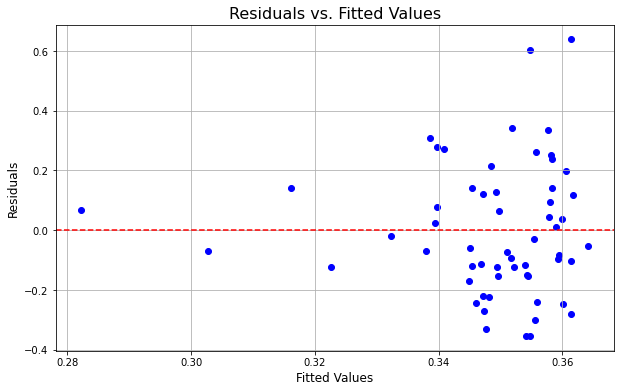

<Figure size 432x432 with 0 Axes>

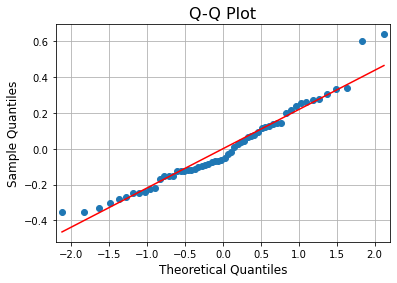

In [30]:
#This cell of code code largely from ChatGPT

#Examining the homoscedacity 
#Resetting x and y to numpy arrays
X = np.array(x)
Y = np.array(y)

# Fit a linear regression model
reg = LinearRegression()
reg.fit(X.reshape(-1, 1), Y)

#Calculate residuals
y_pred = reg.predict(X.reshape(-1, 1))
residuals = Y - y_pred

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, marker='o', color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values', size=12)
plt.ylabel('Residuals', size=12)
plt.title('Residuals vs. Fitted Values', size=16)
plt.grid(True)

# Display the plot
plt.show()

#Examining multivariate normality
# Create the Q-Q plot
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='s')
plt.xlabel('Theoretical Quantiles', size=12)
plt.ylabel('Sample Quantiles', size=12)
plt.title('Q-Q Plot', size=16)
plt.grid(True)

plt.show()

We can see from the residuals vs. fitted plot that errors are fairly randomly distributed around 0.0, suggesting homoscedacity. Our Q-Q plot shows relatively good aherence to the 45 degree line. Given all assumptions for linear regression are approximately met, we can feel relatively confident in our p-value.

We now shift our analysis to examine any possible correlations between AQI and Death Valley annual attendance. We do this because of the poor correlation between smoke estimates and AQI found in the epa_comparison script. We begin with a visual comparison first.

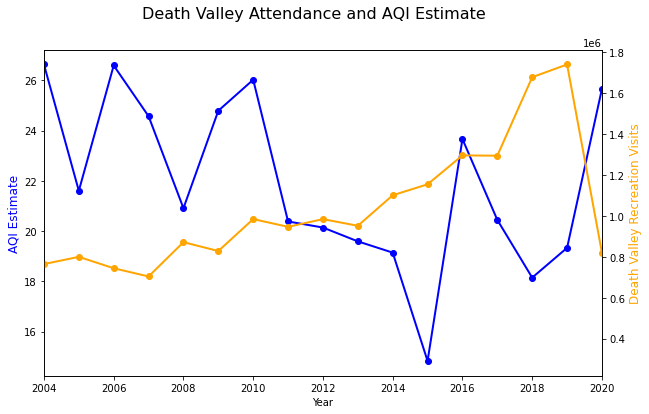

In [31]:
#Plotting the timeseries
x = comp_df['Year']
y_death_valley = comp_df['RecreationVisitors']
y_aqi = comp_df['annual_avg_aqi']

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot()

color = 'blue'
ax1.set_xlabel('Year')
ax1.set_xlim(2004, 2020)
ax1.set_ylabel('AQI Estimate', size=12, color=color)
ax1.plot(x, y_aqi, marker='o', linestyle='solid',
     linewidth=2, markersize=6, color=color)

ax2 = ax1.twinx() #makes second plot which shares x axis

color = 'orange'
ax2.set_ylabel('Death Valley Recreation Visits', size=12, color=color)
ax2.plot(x, y_death_valley, marker='o', linestyle='solid',
     linewidth=2, markersize=6, color = color)

fig.suptitle("Death Valley Attendance and AQI Estimate", size=16)
plt.show()

It is possible that there is some correlation between Death Valley attendance and the AQI estimate. We will plot the two normalized values below, using linear regression to assess the correlation.

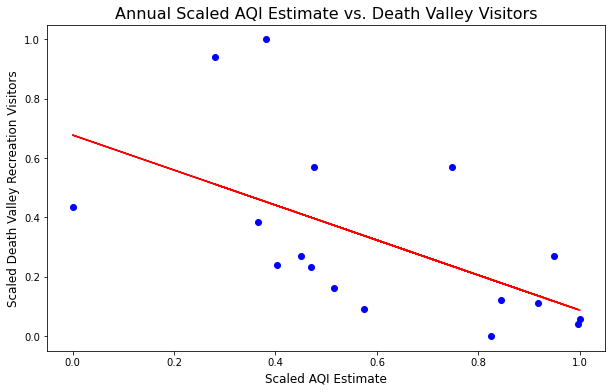

The r-squared value for the linear regression is 0.33.
The p value is 0.02


In [32]:
#Normalizing the columns
limited_df = comp_df[41:]
df_min_max_scaled = limited_df.copy() 
df_min_max_scaled['scaled_aqi'] = (df_min_max_scaled['annual_avg_aqi'] - df_min_max_scaled['annual_avg_aqi'].min()) / (df_min_max_scaled['annual_avg_aqi'].max() - df_min_max_scaled['annual_avg_aqi'].min())     
df_min_max_scaled['scaled_visitors'] = (df_min_max_scaled['RecreationVisitors'] - df_min_max_scaled['RecreationVisitors'].min()) / (df_min_max_scaled['RecreationVisitors'].max() - df_min_max_scaled['RecreationVisitors'].min())     

#Graphing the two columns to see the relationship
x = df_min_max_scaled['scaled_aqi']
y = df_min_max_scaled['scaled_visitors']

slope, intercept, r, p, std_err = stats.linregress(x, y)

def line_eqn(x):
  return slope * x + intercept

mymodel = list(map(line_eqn, x))

plt.figure(figsize=(10, 6))
plt.title("Annual Scaled AQI Estimate vs. Death Valley Visitors", size=16)
plt.scatter(x, y, marker= 'o', color = 'blue')
plt.plot(x, mymodel, c="red")
plt.xlabel('Scaled AQI Estimate', size=12)
plt.ylabel('Scaled Death Valley Recreation Visitors', size=12)
plt.show()

print("The r-squared value for the linear regression is {0}.".format(round(r**2,2)))
print("The p value is {0}".format(round(p,2)))

Here we can see that the correlation is 0.33, much higher than that for the smoke estimate and attendance. It is also statistically significant at a level below 0.05. Thus it is possible that AQI is a better judge of particulate matter than our smoke estimate, and it may have a larger impact on park visitors.

Again, we must test if the linear regression assumptions hold. As seen above, the scaled AQI estimate and Death Valley attendance numbers do seem to be linearly related. We do not believe there is collinearity (correlated variables) or auto-correlation given we only have 2 variables and they are not presented as a time series. However, we should examine if our data follows a normal distribution and has equal variance across datapoints. We will use code from ChatGPT to create the residuals vs. fitted values plot and a Q-Q plot given we typically code these in R. 

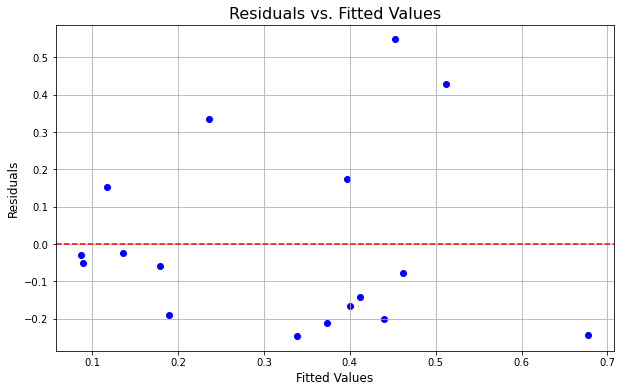

<Figure size 432x432 with 0 Axes>

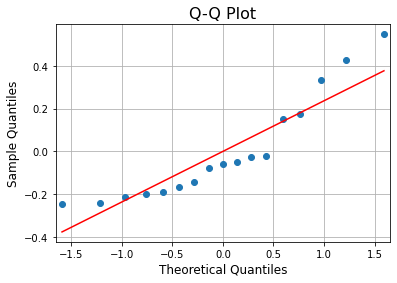

In [33]:
#This cell of code code largely from ChatGPT

#Examining the homoscedacity 
#Resetting x and y to numpy arrays
X = np.array(x)
Y = np.array(y)

# Fit a linear regression model
reg = LinearRegression()
reg.fit(X.reshape(-1, 1), Y)

#Calculate residuals
y_pred = reg.predict(X.reshape(-1, 1))
residuals = Y - y_pred

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, marker='o', color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values', size=12)
plt.ylabel('Residuals', size=12)
plt.title('Residuals vs. Fitted Values', size=16)
plt.grid(True)

# Display the plot
plt.show()

#Examining multivariate normality
# Create the Q-Q plot
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='s')
plt.xlabel('Theoretical Quantiles', size=12)
plt.ylabel('Sample Quantiles', size=12)
plt.title('Q-Q Plot', size=16)
plt.grid(True)

plt.show()

Again, we can see from the residuals vs. fitted plot that errors are fairly randomly distributed around 0.0, suggesting homoscedacity. Our Q-Q plot shows moderate aherence to the 45 degree line, which may be of slight concern given our relatively small sample size (~15 points). We do conform to most of the linear regression assumptions, but the normality of the residuals may impact the accuracy of our p-value.